In [14]:
import theano
from theano import tensor as T
from theano.tensor.nnet import conv2d
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.signal import downsample
import numpy
import numpy as np
import time
import pylab
from PIL import Image
from Data import Load
import csv
import os
import pickle
import sys
from sklearn.utils import shuffle

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

## (1) Parameters
numClasses = 30
numHiddenNodes = 600 
patchWidth = 3
patchHeight = 3
featureMapsLayer1 = 32
featureMapsLayer2 = 64
featureMapsLayer3 = 128

# For convonets, we will work in 2d rather than 1d.  The dataset images are 96 * 96
imageWidth = 96

# Convolution layers.  
w_1 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01))))
w_2 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth, patchHeight))*.01))))
w_3 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth, patchHeight))*.01))))

# Fully connected NN. 
w_4 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer3 * 11 * 11, numHiddenNodes))*.01))))
w_5 = theano.shared(floatX(np.asarray((np.random.randn(*(numHiddenNodes, numHiddenNodes))*.01))))
w_6 = theano.shared(floatX(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01))))

# Bias values
b_1 = theano.shared(value=numpy.zeros((featureMapsLayer1,), dtype=theano.config.floatX), borrow=True)
b_2 = theano.shared(value=numpy.zeros((featureMapsLayer2,), dtype=theano.config.floatX), borrow=True)
b_3 = theano.shared(value=numpy.zeros((featureMapsLayer3,), dtype=theano.config.floatX), borrow=True)
b_4 = theano.shared(value=numpy.zeros((numHiddenNodes,), dtype=theano.config.floatX), name='b', borrow=True)
b_5 = theano.shared(value=numpy.zeros((numHiddenNodes,), dtype=theano.config.floatX), name='b', borrow=True)
b_6 = theano.shared(value=numpy.zeros((numClasses,), dtype=theano.config.floatX), name='b', borrow=True)

params = [w_1, w_2, w_3, w_4, w_5, w_6, b_1, b_2, b_3, b_4, b_5, b_6]

## (2) Model
X = T.matrix('X').reshape((-1, 1, 96, 96)) # conv2d works with tensor4 type
Y = T.matrix('Y')

srng = RandomStreams()
def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p, dtype=theano.config.floatX)
        X /= 1 - p
    return X

# Theano provides built-in support for add convolutional layers
def model(X, w_1, w_2, w_3, w_4, w_5, w_6, p_1, p_2):
    l1 = dropout(T.tanh( max_pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'),0.), (2, 2)) + b_1.dimshuffle('x', 0, 'x', 'x') ), p_1)
    l2 = dropout(T.tanh( max_pool_2d(T.maximum(conv2d(l1, w_2), 0.), (2, 2)) + b_2.dimshuffle('x', 0, 'x', 'x') ), p_1)
    l3 = dropout(T.flatten(T.tanh( max_pool_2d(T.maximum(conv2d(l2, w_3), 0.), (2, 2)) + b_3.dimshuffle('x', 0, 'x', 'x') ), outdim=2), p_1)# flatten to switch back to 1d layers
    l4 = dropout(T.maximum(T.dot(l3, w_4) + b_4, 0.), p_2)
    l5 = dropout(T.maximum(T.dot(l4, w_5) + b_5, 0.), p_2)
    return T.dot(l5, w_6) + b_6

y_hat_train = model(X, w_1, w_2, w_3, w_4, w_5, w_6, 0.2, 0.5)
y_hat_predict = model(X, w_1, w_2, w_3, w_4, w_5, w_6, 0., 0.)

## (3) Cost
cost = ((Y - (y_hat_predict))**2).mean()

## (4) Minimization.  
def backprop(cost, w, alpha=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        
        # adding gradient scaling
        acc = theano.shared(w1.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * grad ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        grad = grad / gradient_scaling
        updates.append((acc, acc_new))
        
        updates.append((w1, w1 - grad * alpha))
    return updates

update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
y_pred = y_hat_predict
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

################################################################################
# Model Execution
################################################################################
all_X, all_Y = Load.load()
rot_X, rot_Y = Load.rotate_images(all_X, all_Y)
blur_X, blur_Y = Load.blurr_images(all_X, all_Y)
tr_X, tr_Y = Load.transpose_images(all_X, all_Y)

all_X, all_Y = np.vstack((all_X, rot_X)), np.vstack((all_Y, rot_Y))
all_X, all_Y = np.vstack((all_X, blur_X)), np.vstack((all_Y, blur_Y))
all_X, all_Y = np.vstack((all_X, tr_X)), np.vstack((all_Y, tr_Y))
all_X, all_Y = shuffle(all_X, all_Y, random_state=42)  # shuffle data
rot_X, rot_Y, blur_X, blur_Y, tr_X, tr_Y = None, None, None, None, None, None

test_indices = np.random.choice(all_X.shape[0], .2*all_X.shape[0], replace=False)
keep = np.ones(all_X.shape[0], dtype=bool) # array of True matching 1st dim
keep[test_indices] = False
trX = all_X[keep,:]
trY = all_Y[keep,:]

deX = all_X[test_indices]
deY = all_Y[test_indices]

trX = trX.reshape(-1, 1, imageWidth, imageWidth)
deX = deX.reshape(-1, 1, imageWidth, imageWidth)

miniBatchSize = 1
def gradientDescentStochastic(epochs):
    training_costs=[]
    dev_costs=[]
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(trX), miniBatchSize), range(miniBatchSize, len(trX), miniBatchSize)):
            cost = train(trX[start:end], trY[start:end])
        
        # Compute overall dev and training costs after epoch
        pdeY = predict(deX)
        cost_de = ((deY - pdeY)**2).mean()
        
        ptrY = predict(trX)
        cost_tr = ((trY - ptrY)**2).mean()
        
        # Capture the traning and dev costs on each epoch
        training_costs.append(cost_tr)
        dev_costs.append(cost_de)
        
        print '%d) precision=%.8f, Traning cost=%.8f, DE cost: %.8f' %(i+1, np.mean(np.allclose(deY, pdeY)), cost, cost_de)
        trainTime =  trainTime + (time.time() - start_time)
    print 'train time = %.2f' %(trainTime)
    
    return training_costs, dev_costs

training_costs, dev_costs = gradientDescentStochastic(100)

print 'Mean squared error on Training data: %.8f\n'%((trY - trY.mean())**2).mean()
print 'Mean squared error on Dev data: %.8f\n'%((deY - deY.mean())**2).mean()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:70: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=False is needed to use CuDNN. When using ignore_border=False and not using CuDNN, the only GPU combination supported is when `ds == st and padding == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:71: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=False is needed to use CuDNN. When using ignore_border=False and not using CuDNN, the only GPU combination supported is when `ds 

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:118: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


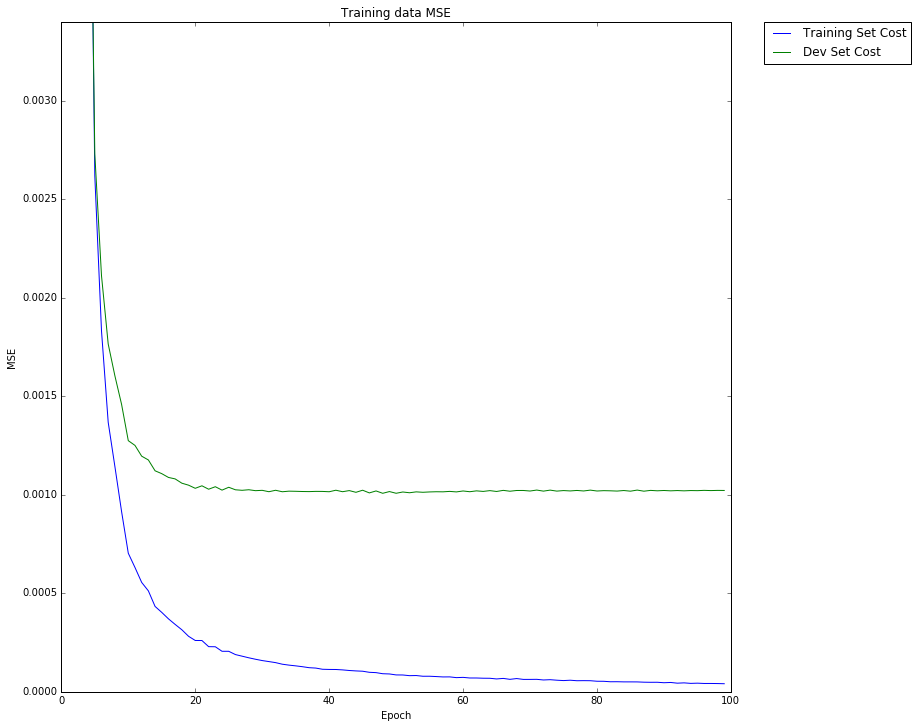

In [20]:
%matplotlib inline
import matplotlib.colors as clrs
import matplotlib.pyplot as plt

# Plot the trainig data costs over time
plt.figure(figsize=(12, 12))
training_plt = plt.plot(training_costs, c='b', label='Training Set Cost')
dev_plt = plt.plot(dev_costs, c='g', label='Dev Set Cost')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training data MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.axis([0, 100, 0, 0.0034])
plt.show()

In [21]:
def plot_sample(axis, x, y, y_pred=None,):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', c='r', s=10)
    
    if y_pred is not None:
        axis.scatter(y[0::2] * 48 + 48, y_pred[1::2] * 48 + 48, marker='x', s=10)

[576 507 452 296 528 309 194 328  47  80 297 579  54   1 535 540 601 520
 427 615]
[ 0.01487054  0.01247014  0.01085445  0.01020585  0.00988082  0.0095406
  0.00937741  0.00816987  0.00800118  0.00787128  0.00766487  0.00701572
  0.00687708  0.00648226  0.00630075  0.00622219  0.00583947  0.0054899
  0.00512692  0.00509358]


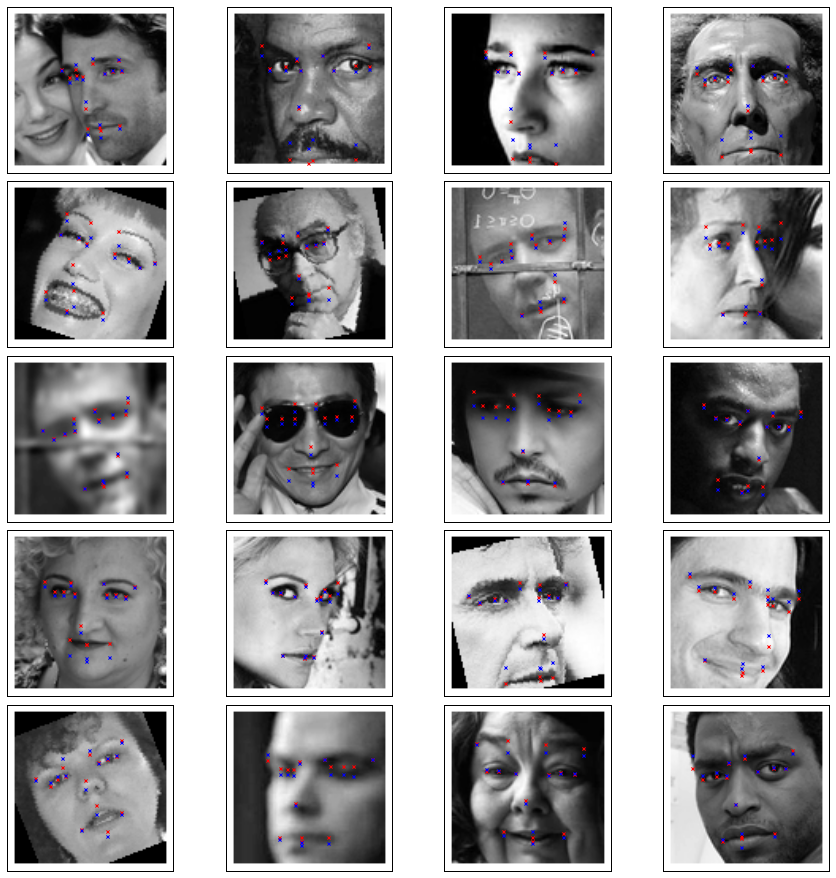

In [22]:
# Find the dev set images with the highest costs
final_pdeY = predict(deX)
final_cost_de = ((deY - final_pdeY)**2).mean(axis=1)
final_ptrY = predict(trX)
final_cost_tr = ((trY - final_ptrY)**2).mean(axis=1)

# Print the highest dev set indices
highest_dev_indices = np.array(final_cost_de).argsort()[::-1][:20]
print highest_dev_indices

# Print the highest dev costs
highest_dev_costs = final_cost_de.copy()
highest_dev_costs.sort()
print highest_dev_costs[::-1][:20]

# Plot the images with the highest dev costs
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    plot_sample(ax, deX[highest_dev_indices[i]], deY[highest_dev_indices[i]], final_pdeY[highest_dev_indices[i]])

('Quartiles: ', array([  6.10071693e-05,   2.50072131e-04,   4.97089815e-04,
         1.04379922e-03]))


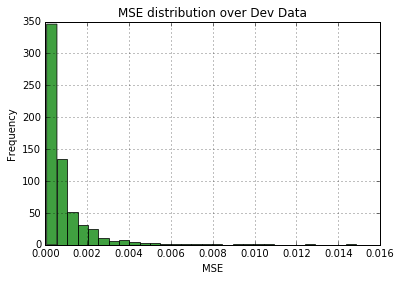

('Quartiles: ', array([  2.23251459e-06,   2.36223059e-05,   3.52661955e-05,
         5.11365597e-05]))


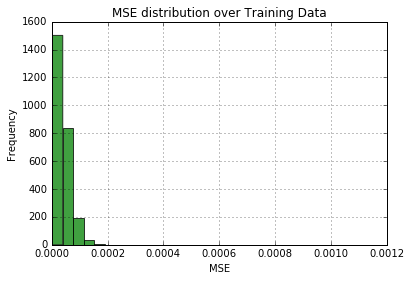

In [24]:
# Let's look into the distribution of the costs on the dev data
print('Quartiles: ', np.percentile(final_cost_de, np.arange(0, 100, 25))) # quartiles
n, bins, patches = plt.hist(final_cost_de, bins=30, facecolor='green', alpha=0.75)

plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE distribution over Dev Data')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

# Let's look at the Training Data ditribution
print('Quartiles: ', np.percentile(final_cost_tr, np.arange(0, 100, 25))) # quartiles
n, bins, patches = plt.hist(final_cost_tr, bins=30, facecolor='green', alpha=0.75)

plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE distribution over Training Data')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()